In [12]:
import numpy as np
from math import log
import numpy.random as rn
import graph_tool as gt
from numba import jit, vectorize, float64, int32, int64
import pickle as cp
import itertools
from matplotlib import pyplot as plt
%matplotlib inline
import nbimporter
from COVERfinalig import *
import copy

In [13]:

def vmtoG(VM,M):#creates graph corresponding to configuration given my vertex maps and motifs
    elist=[]
    for i in range(len(VM)):
        for vmap in VM[i]:
            for e in M[i].edges():
                elist.append([vmap[M[i].vertex_index[e.source()]],vmap[M[i].vertex_index[e.target()]]])
    g=gt.Graph(directed=M[0].is_directed())
    g.add_edge_list(elist)
    return g
def CtoG(C):
    return vmtoG(C[0],C[1])


In [20]:
#Functions for shuffling subgraph configuration for different models 
def randomize(vm,m,SN,o):
    for s in range(SN):
        a=rn.choice(len(vm),2)
        i1=rn.choice(list(m.gp.orbits[o]))
        i2=rn.choice(list(m.gp.orbits[o]))
        o1=vm[a[0]][i1]
        o2=vm[a[1]][i2]
        if (vm[a[0]][i1] not in [i for i in vm[a[1]] if i!=vm[a[1]][i2]]) and (vm[a[1]][i2] not in [i for i in vm[a[0]] if i!=vm[a[0]][i1]]):
            vm[a[0]][i1]=o2
            vm[a[1]][i2]=o1
    return vm
def randomizeH(vm,m,N): #non-DC model
    for i in range(len(vm)):
        vm[i]=np.random.choice(N,len(vm[i]),replace=False).list
    return vm
#@jit
def randomizeNO(vm,m,SN):#motif degree model
    for s in range(SN):
        a=rn.choice(len(vm),2)
        i1=rn.choice(range(m.num_vertices()))
        i2=rn.choice(range(m.num_vertices()))
        o1=vm[a[0]][i1]
        o2=vm[a[1]][i2]
        if (vm[a[0]][i1] not in [i for i in vm[a[1]] if i!=vm[a[1]][i2]]) and (vm[a[1]][i2] not in [i for i in vm[a[0]] if i!=vm[a[0]][i1]]):
            vm[a[0]][i1]=o2
            vm[a[1]][i2]=o1
    return vm

#@jit
def randomizeCO(c,SN):
    C=copy.deepcopy(c)
    for i in range(len(C[1])):
        for o in range(len(C[1][i].gp.orbits)):
            C[0][i]=randomize(C[0][i],C[1][i],SN*len(C[0][i])*len(C[1][i].gp.orbits[o]),o)
    return C
#@jit     
def randomizeCNO(c,SN):
    C=copy.deepcopy(c)
    for i in range(len(C)):
        C[i][0]=randomizeNO(C[0][i],C[1][i],SN*len(C[0][i])*C[1][i].num_vertices())
    return C
#@jit
def randomizeCH(C):
    VM=C[0]
    M=C[1]
    g=vmtoG(VM,M)
    N=g.num_vertices()
    cr=copy.deepcopy(C)
    for i in range(len(cr[0])):
        cr[0][i]=randomizeH(C[0][i],C[1][i],N)
    return cr
#@jit
def randomizeCA(CS,SN):
    C=copy.deepcopy(CS)
    M=C[1]
    print(M[0])
    CA=[[t,j] for j in range(len(M)) for t in C[0][j]]
    chA=[i for i in range(len(CA)) for j in range(len(CA[i][0]))]
    for tt in range(SN*len(chA)):
        a=rn.choice(chA,2)
        i1=rn.choice(range(M[CA[a[0]][1]].num_vertices()))
        i2=rn.choice(range(M[CA[a[1]][1]].num_vertices()))
        o1=CA[a[0]][0][i1]
        o2=CA[a[1]][0][i2]
        if (o1 not in [i for i in CA[a[1]][0] if i!=o2]) and (o2 not in [i for i in CA[a[0]][0] if i!=o1]):
            CA[a[0]][0][i1]=o2
            CA[a[1]][0][i2]=o1
    Ms=[]
    m0=CA[0][1]
    vmap=[]
    cc=[]
    for i in CA:
        if i[1]==m0:
            cc.append(i[0])
        else:
            vmap.append(cc)
            Ms.append(M[m0])
            m0=i[1]
            cc=[i[0]]
    vmap.append(cc)
    Ms.append(M[m0])
    return [vmap,Ms]
#@jit
def randomizeCDAS(CS,SN):
    C=copy.deepcopy(CS)
    M=C[1]
    mdict={}
    for m in range(len(M)): #determine the orbit types of vertices of m
        vt=[[],[],[]]
        for v in range(M[m].num_vertices()):
                if M[m].vp.orbtype[v]==0:
                    vt[0].append(v)
                elif M[m].vp.orbtype[v]==1:
                    vt[1].append(v)
                elif M[m].vp.orbtype[v]==2:
                    vt[2].append(v)
        mdict[m]=vt
    CA=[[t,j] for j in range(len(M)) for t in C[0][j]]
    for t in range(3):
        chA=[i for i in range(len(CA)) for j in range(len(mdict[i[1]][t]))]
        for tt in range(SN):
            a=rn.choice(chA,2)
            i1=rn.choice(mdict[CA[a[0]][1]][t])
            i2=rn.choice(mdict[CA[a[1]][1]][t])
            o1=CA[a[0]][0][i1]
            o2=CA[a[1]][0][i2]
            if (o1 not in [i for i in CA[a[1]][0] if i!=o2]) and (o2 not in [i for i in CA[a[0]][0] if i!=o1]):
                CA[a[0]][0][i1]=o2
                CA[a[1]][0][i2]=o1
    Ms=[]
    m0=CA[0][1]
    vmap=[]
    cc=[]
    for i in CA:
        if i[1]==m0:
            cc.append(i[0])
        else:
            vmap.append(cc)
            Ms.append(M[m0])
            m0=i[1]
            cc=[i[0]]
    vmap.append(cc)
    Ms.append(M[m0])
    return [vmap,Ms]
    
        

In [4]:
np.random.choice(100,3,replace=False)

array([33, 88, 14])

In [67]:
def genDCS(m,D): # generate configuration of m-subgraphs for given orbit degree sequence D
    Dv=[rn.permutation(list(itertools.chain.from_iterable([[i]*ds[i] for i in range(len(ds))]))) for ds in D]
    print(len(Dv[0]))
    diter=[iter(d) for d in Dv]
    n=np.sum(D[0])/len(m.gp.orbits[0])
    print(n)
    vm=[]
    for i in range(int(n)):
        vm.append([next(diter[o]) for o in m.gp.orbmem])
    return vm
def genDCSC(M,Ds):
    C=[]
    for i in range(len(M)):
        D=[rn.permutation(Ds[i]*len(o)) for o in M[i].gp.orbits]
        C.append([genDCS(M[i],D),M[i]])
    return randomizeCO(C,100)
def genDCSCO(M,Ds,nm):
    vm=[]
    for i in range(len(M)):
        D=[sample(Ds[i][j],len(M[i].gp.orbits[j])*nm[i]) for j in  range(len(M[i].gp.orbits))]
        print(D[0][0])
        vm.append(genDCS(M[i],D))
    return randomizeCO([vm,M],100)
def genDCSNO(m,ds):
    Dv=rn.permutation(list(itertools.chain.from_iterable([[i]*ds[i] for i in range(len(ds))]))) 
    print(len(Dv))
    diter=iter(Dv)
    n=np.sum(ds)/m.num_vertices()
    print(n)
    vm=[]
    for i in range(n):
        vm.append([diter.next() for o in m.gp.orbmem])
    return vm
def genDCSCNO(M,Ds,nm):
    C=[]
    for i in range(len(M)):
        C.append([genDCSNO(M[i],sample(Ds[i],nm[i]*M[i].num_vertices())),M[i]])
    return randomizeCNO(C,100)    
def genDCSCA(M,dS,nm):
    n=sum([nm[i]*M[i].num_vertices() for i in range(len(M))])
    print(n)
    Dv=sampleS(dS,n)
    print(len(Dv))
    vmap=[]
    t=0
    for i in range(len(nm)):
        vm=[]
        for j in range(nm[i]):
            vm.append(Dv[t:t+M[i].num_vertices()])
            t+=M[i].num_vertices()
        vmap.append(vm)
    return randomizeCA([vmap,M],10)
        
def sample(ds,n):
    d=list(rn.choice(list(itertools.chain.from_iterable([[i]*ds[i] for i in range(len(ds))])),n))
    return np.array([d.count(i) for i in range(len(ds))])
def sampleS(ds,n):
    return list(rn.choice(list(itertools.chain.from_iterable([[i]*ds[i] for i in range(len(ds))])),n))
    
        

In [122]:
f=open('BDmotifs5','rb')
M=cp.load(f)
f.close()
print(len(M))

7585


[(2, 1, 1), (3, 3, 3), (3, 5, 1), (4, 7, 2), (5, 11, 2), (5, 20, 120)]


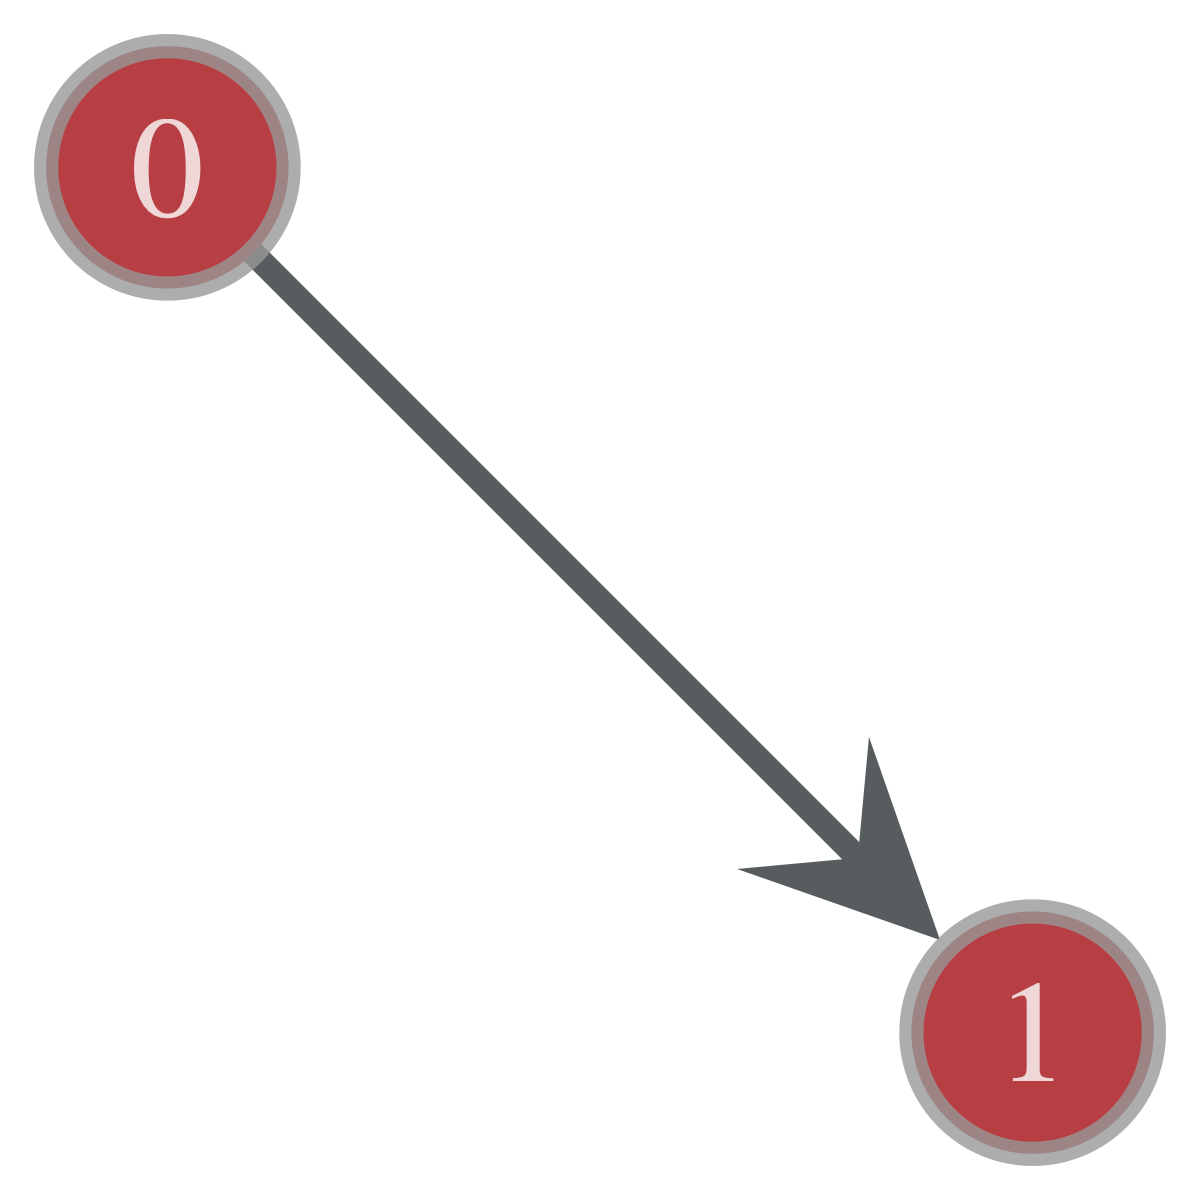

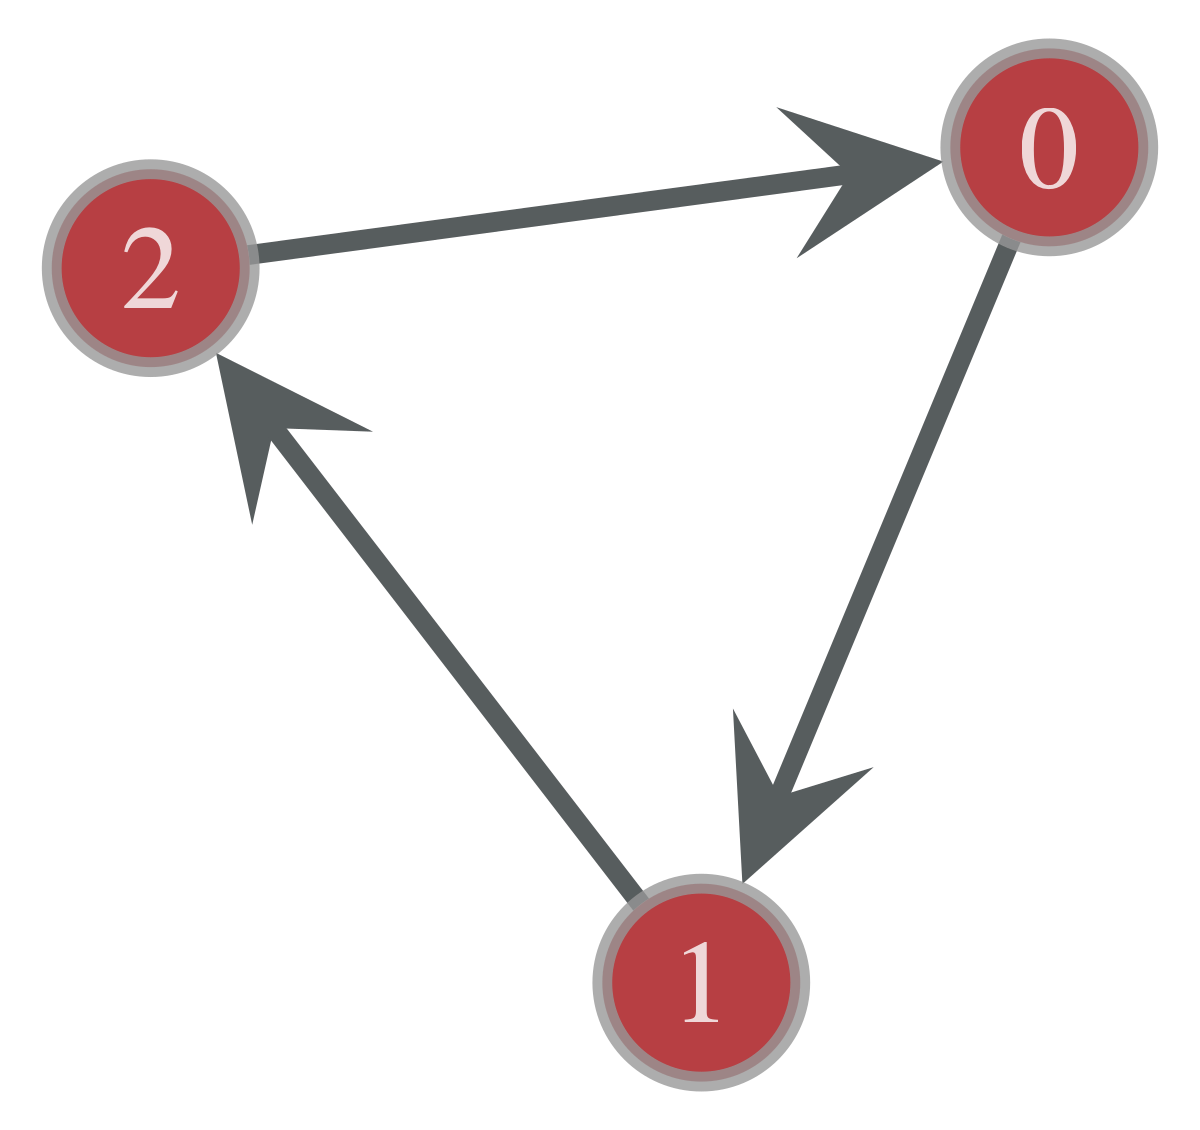

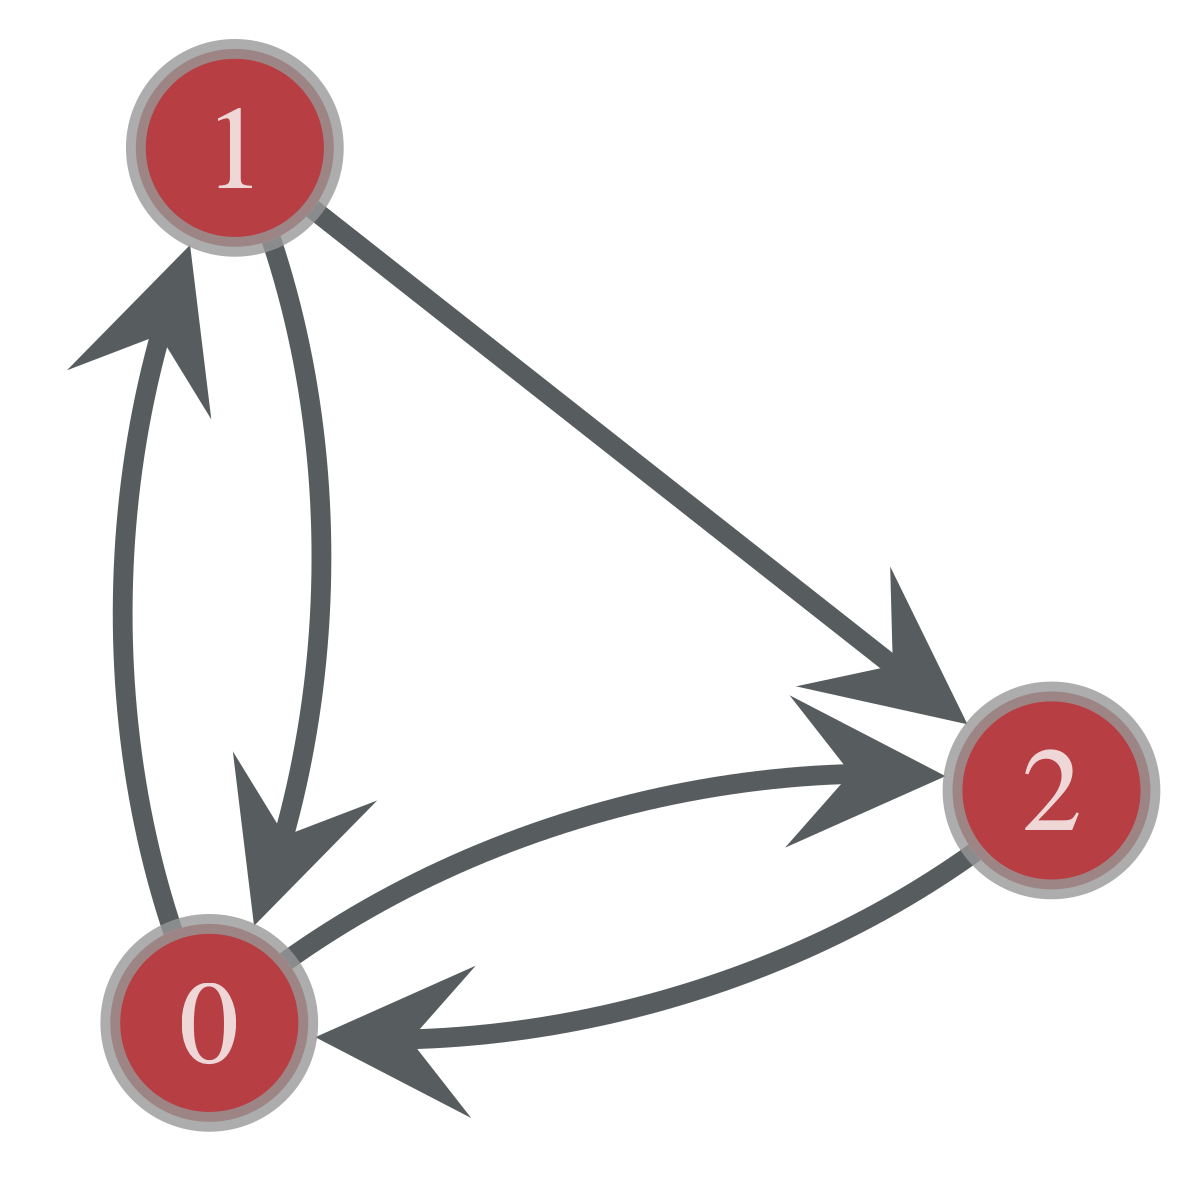

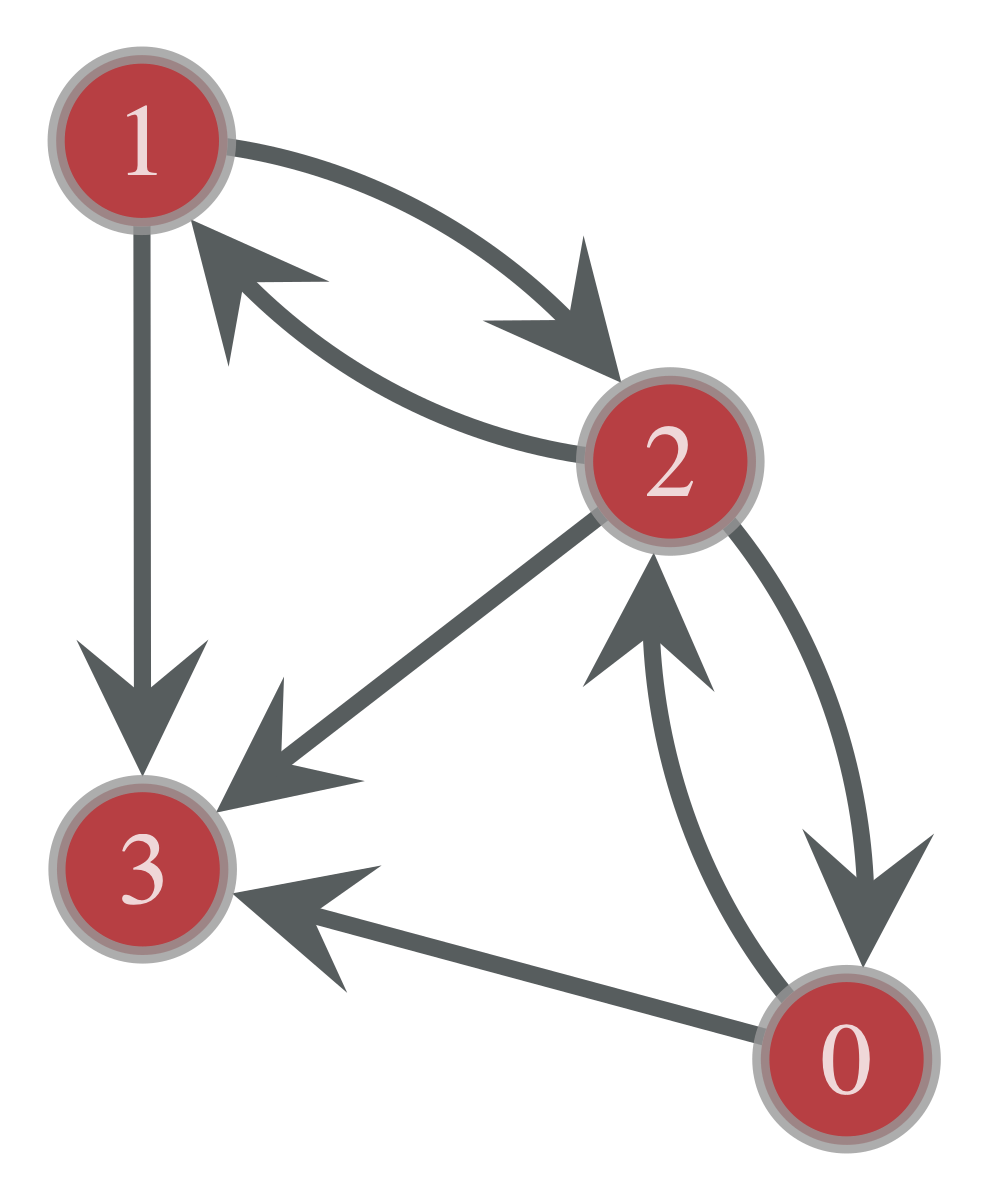

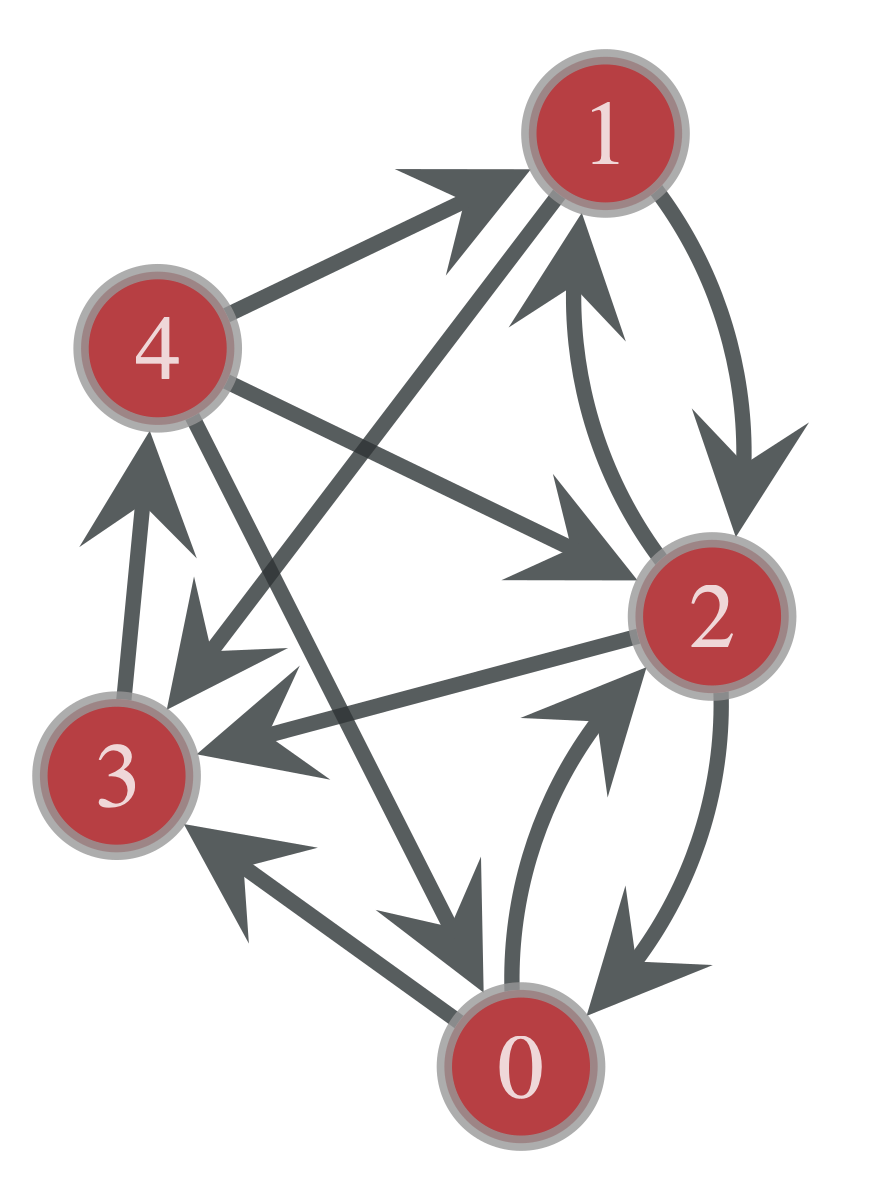

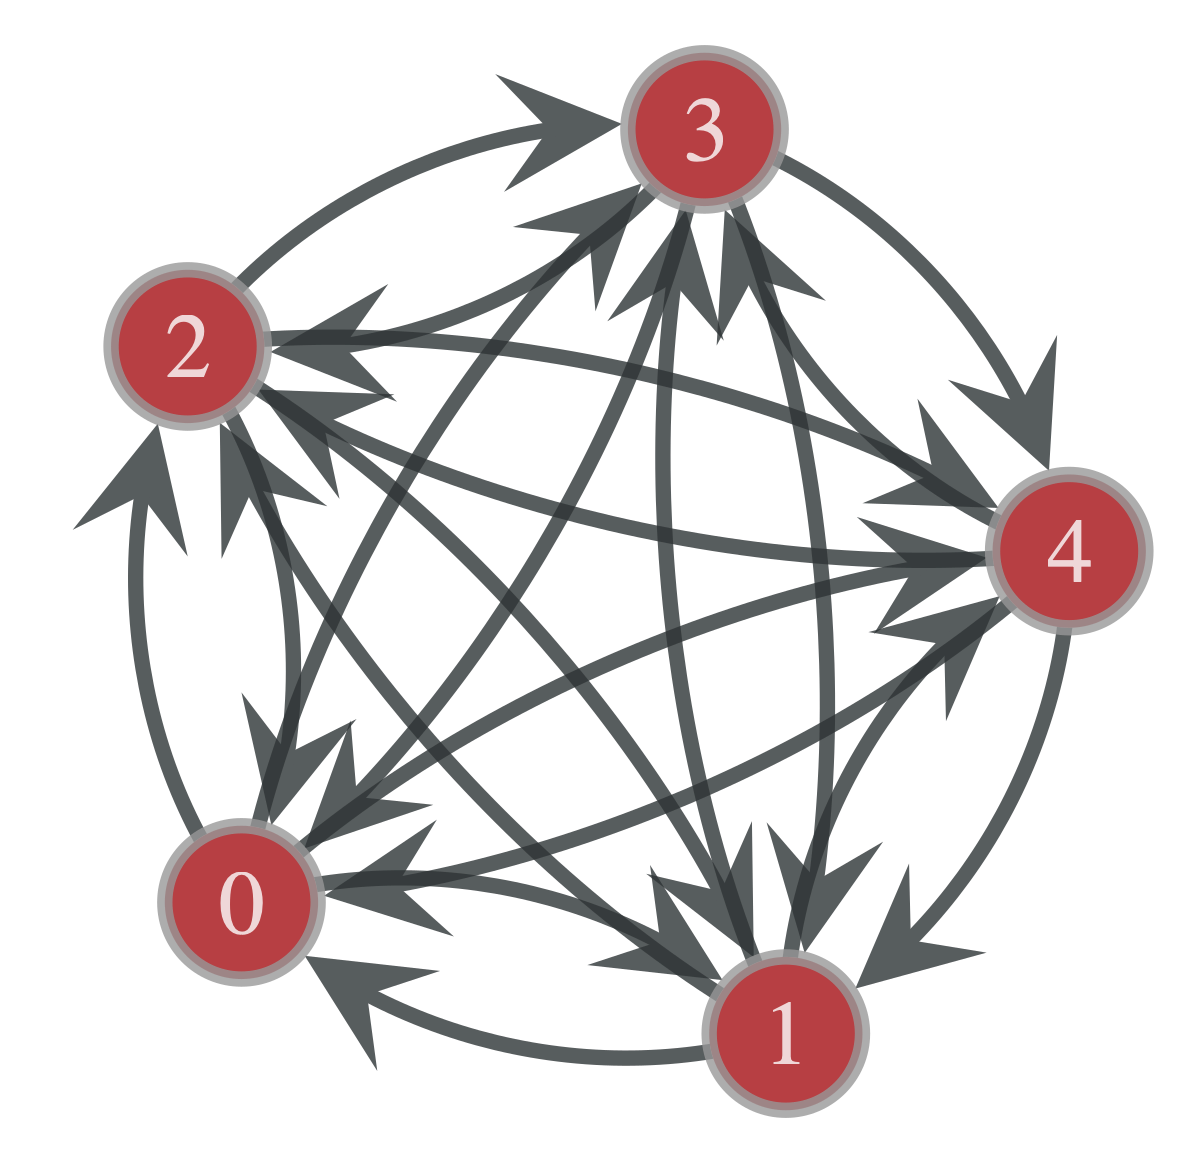

In [123]:
ms=[M[0],M[1]]
ms=[M[0],M[3],M[7],M[58],M[5995],M[-1]]
#ms=[M[0],M[1],M[10],M[15],M[25],M[-1]]
#ms=[M[0],M[5],M[29],M[105],M[150],M[-1]]
print([(m.num_vertices(),m.num_edges(),m.gp.hom) for m in ms])
from graph_tool.draw import graph_draw

for m in ms:
    ug = gt.GraphView(m)
    
    graph_draw(ug,vertex_text=m.vertex_index.copy())

In [130]:
ms2=ms
#[M[0],M[10],M[30],M[90],M[150],M[538],M[2356]]

#ms2=[M[0],M[1],M[10],M[15],M[70],M[238],M[532]]
#ms=[M[0],M[5],M[29],M[105],M[150],M[-1]]
#Ds=[[rn.zipf(4,2000) for o in m.gp.orbits] for m in ms2]
Ds=rn.zipf(4,2000)
CRR=genDCSCA(ms2,Ds,[500,100,100,100,100,25])
#CRR=genDCSCN(ms2,Ds,[1500,1000])
g=CtoG(CRR)
print(g)


2625
2625
<Graph object, directed, with 2 vertices and 1 edge, 6 internal graph properties, at 0x1e48d0940>
<Graph object, directed, with 2000 vertices and 3600 edges, at 0x1dcc6eb60>


In [131]:
g.save('SData/Synth4.gml')
f=open('Sdata/Synth4GT','wb')
cp.dump(CRR,f)
f.close()

In [5]:
#functions for doing motif analysis ala Mile/Alon et al. with random SGCMs
from graph_tool.clustering import motifs

def countU(g,M):
    gt.remove_parallel_edges(g)
    k=M[0].num_vertices()
    t=motifs(g,k,motif_list=M)
    return [t[1][i] for i in range(len(M))]
def countD(g,M):
    gt.remove_parallel_edges(g)
    k=M[0].num_vertices()
    t=motifs(g,k,motif_list=M)
    return [t[1][i] for i in range(len(M))],t[0]
def MsigDCD4(C,M3,M4):
    g=CtoG(C)
    c03=np.array(countD(g,M3)[0])
    c04=np.array(countD(g,M4)[0])
    c0=np.concatenate((c03,c04),axis=0)
    cnts=[]
    cnts4=[]
    for i in range(10):
        C=randomizeCO(C,10000)
        g=CtoG(C)
        cnts.append(countD(g,M3)[0])
        cnts4.append(countD(g,M4)[0])
    cz=np.concatenate((np.array(cnts),np.array(cnts4)),axis=1)
    print(np.mean(cz,axis=0),np.std(cz,axis=0),(np.mean(cz,axis=0)-c0)/np.std(cz,axis=0),c0)
    return cnts,c0
def MsigAD4(C,M3,M4):
    g=CtoG(C)
    c03=np.array(countD(g,M3)[0])
    c04=np.array(countD(g,M4)[0])
    c0=np.concatenate((c03,c04),axis=0)
    cnts=[]
    cnts4=[]
    for i in range(10):
        C=randomizeCA(C,10000)
        g=CtoG(C)
        cnts.append(countD(g,M3)[0])
        cnts4.append(countD(g,M4)[0])
    cz=np.concatenate((np.array(cnts),np.array(cnts4)),axis=1)
    print(np.mean(cz,axis=0),np.std(cz,axis=0),(np.mean(cz,axis=0)-c0)/np.std(cz,axis=0),c0)
    return cnts,c0
def MsigAD(C,M3):
    g=CtoG(C)
    c0=np.array(countD(g,M3)[0])
    cnts=[]
    for i in range(10):
        C=randomizeCA(C,1000)
        g=CtoG(C)
        cnts.append(countD(g,M3)[0])
    cz=np.array(cnts)
    print(np.mean(cz,axis=0),np.std(cz,axis=0),(np.mean(cz,axis=0)-c0)/np.std(cz,axis=0),c0)
    return cnts,c0,(np.mean(cz,axis=0)-c0)/np.std(cz,axis=0)
def MsigDASD(C,M3):
    g=CtoG(C)
    c0=np.array(countD(g,M3)[0])
    print(c0)
    cnts=[]
    for i in range(10):
        C=randomizeCDAS(C,10)
        g=CtoG(C)
        cnts.append(countD(g,M3)[0])
        print(cnts[-1])
    cz=np.array(cnts)
    print(np.mean(cz,axis=0),np.std(cz,axis=0),(np.mean(cz,axis=0)-c0)/np.std(cz,axis=0),c0)
    return cnts,c0,(np.mean(cz,axis=0)-c0)/np.std(cz,axis=0)
def MsigED(C,M3):
    g=CtoG(C)
    c0=np.array(countD(g,M3)[0])
    cnts=[]
    for i in range(10):
        random_rewire(g)
        cnts.append(countD(g,M3)[0])
    cz=np.array(cnts)
    print(np.mean(cz,axis=0),np.std(cz,axis=0),(np.mean(cz,axis=0)-c0)/np.std(cz,axis=0),c0)
    return cnts,c0,(np.mean(cz,axis=0)-c0)/np.std(cz,axis=0)
def MsigDCD(C,M3):
    g=CtoG(C)
    ct=countD(g,M3)
    c0=np.array(ct[0])
    print(c0)
    cnts=[]
    for i in range(10):
        C=randomizeCO(C,100)
        g=CtoG(C)
        cnts.append(countD(g,M3)[0])
        print(cnts[-1])
    cz=np.array(cnts)
    #print(np.mean(cz,axis=0),np.std(cz,axis=0),(np.mean(cz,axis=0)-c0)/np.std(cz,axis=0),c0)
    return cnts,c0,(np.mean(cz,axis=0)-c0)/np.std(cz,axis=0),ct[1]
    
def MsigDCU(C,M3,M4):
    t=[]
    c4=[]
    d4=[]
    k4=[]
    g=CtoG(C)
    g.set_directed(False)
    gt.remove_parallel_edges(g)
    c0=countU(g,M3)+countU(g,M4)
    for i in range(10):
        C=randomizeC(C,100)
        g=CtoG(C)
        g.set_directed(False)
        ct=countU(g,M3)
        t.append(ct[0])
        c=countU(g,M4)
        c4.append(c[0])
        d4.append(c[1])
        k4.append(c[2])
    return [(np.mean(t),np.std(t)),(np.mean(c4),np.std(c4)),(np.mean(d4),np.std(d4)),(np.mean(k4),np.std(k4))],c0,[t,c4,d4,k4]
def MsigAU(C,M3,M4):
    t=[]
    c4=[]
    d4=[]
    k4=[]
    g=CtoG(C)
    g.set_directed(False)
    gt.remove_parallel_edges(g)
    c0=countU(g,M3)+countU(g,M4)
    for i in range(10):
        C=randomizeCA(C,100)
        g=CtoG(C)
        g.set_directed(False)
        ct=countU(g,M3)
        t.append(ct[0])
        c=countU(g,M4)
        c4.append(c[0])
        d4.append(c[1])
        k4.append(c[2])
    return [(np.mean(t),np.std(t)),(np.mean(c4),np.std(c4)),(np.mean(d4),np.std(d4)),(np.mean(k4),np.std(k4))],c0,[t,c4,d4,k4]
def MsigE(C,M3,M4):
    t=[]
    c4=[]
    d4=[]
    k4=[]
    g=CtoG(C)
    g.set_directed(False)
    gt.remove_parallel_edges(g)
    c0=countU(g,M3)+countU(g,M4)
    for i in range(10):
        random_rewire(g,n_iter=10)
        ct=countU(g,M3)
        t.append(ct[0])
        c=countU(g,M4)
        c4.append(c[0])
        d4.append(c[1])
        k4.append(c[2])
    return [(np.mean(t),np.std(t)),(np.mean(c4),np.std(c4)),(np.mean(d4),np.std(d4)),(np.mean(k4),np.std(k4))],c0,[t,c4,d4,k4]

In [84]:

f=open('Umotifs4','rb')
MBD=cp.load(f)
f.close()
M3=[]
M4=[]
for m in MBD: 
    if m.num_vertices()==3:
        M3.append(m)
    if m.num_vertices()==4:
        M4.append(m)
M3=[M3[1]]
M4=M4[3:]

In [6]:
f=open('Dmotifs3','rb')
MD=cp.load(f)
f.close()
MD3=[m for m in MD if m.num_vertices()==3]

In [7]:
th=open('Meta/AA.dat.gz.gmlAD5lad','rb')
C=cp.load(th)
th.close()
g=CtoG(C)

In [8]:
ca=MsigDASD(C,MD3)

[12788 11714 24689     0   432   385     0     0     0    11     0     0
     0]
[8023, 7388, 16022, 114, 1102, 1024, 41, 10, 12, 30, 40, 6, 2]
[7276, 7174, 15168, 98, 1114, 1097, 27, 12, 5, 47, 24, 3, 0]
[8551, 6940, 15881, 132, 1068, 877, 57, 7, 6, 41, 17, 2, 0]
[7637, 7574, 16001, 96, 1056, 1036, 44, 18, 10, 37, 31, 14, 1]
[7205, 8653, 16288, 114, 868, 1046, 40, 5, 16, 31, 6, 2, 0]
[8128, 7039, 15775, 137, 1371, 1215, 55, 16, 13, 48, 39, 14, 1]
[7840, 7546, 15944, 98, 1112, 1104, 44, 18, 12, 40, 33, 6, 3]
[7029, 7499, 14972, 127, 1167, 1214, 43, 13, 14, 52, 25, 8, 0]
[7836, 8444, 16835, 164, 714, 783, 50, 9, 11, 14, 21, 5, 0]
[7300, 7777, 15546, 93, 1018, 1051, 35, 12, 15, 32, 44, 7, 1]
[7.68250e+03 7.60340e+03 1.58432e+04 1.17300e+02 1.05900e+03 1.04470e+03
 4.36000e+01 1.20000e+01 1.14000e+01 3.72000e+01 2.80000e+01 6.70000e+00
 8.00000e-01] [456.70105102 533.18780931 505.75068957  21.65663871 165.51978734
 126.9141836    8.48763807   4.19523539   3.41174442  10.53375527
  11.1085

In [9]:
ca

([[8023, 7388, 16022, 114, 1102, 1024, 41, 10, 12, 30, 40, 6, 2],
  [7276, 7174, 15168, 98, 1114, 1097, 27, 12, 5, 47, 24, 3, 0],
  [8551, 6940, 15881, 132, 1068, 877, 57, 7, 6, 41, 17, 2, 0],
  [7637, 7574, 16001, 96, 1056, 1036, 44, 18, 10, 37, 31, 14, 1],
  [7205, 8653, 16288, 114, 868, 1046, 40, 5, 16, 31, 6, 2, 0],
  [8128, 7039, 15775, 137, 1371, 1215, 55, 16, 13, 48, 39, 14, 1],
  [7840, 7546, 15944, 98, 1112, 1104, 44, 18, 12, 40, 33, 6, 3],
  [7029, 7499, 14972, 127, 1167, 1214, 43, 13, 14, 52, 25, 8, 0],
  [7836, 8444, 16835, 164, 714, 783, 50, 9, 11, 14, 21, 5, 0],
  [7300, 7777, 15546, 93, 1018, 1051, 35, 12, 15, 32, 44, 7, 1]],
 array([12788, 11714, 24689,     0,   432,   385,     0,     0,     0,
           11,     0,     0,     0]),
 array([-11.17908529,  -7.70947859, -17.49043587,   5.416353  ,
          3.78806673,   5.19800058,   5.13688256,   2.86038777,
          3.34139918,   2.48724214,   2.5205798 ,   1.62451096,
          0.81649658]))

In [10]:
cd=MsigDCD(C,MD3)

[9.49790e+03 8.81210e+03 1.86313e+04 1.55100e+02 1.40440e+03 1.38530e+03
 8.59000e+01 2.10000e+01 1.87000e+01 5.04000e+01 7.51000e+01 1.79000e+01
 2.90000e+00] [384.38742175 308.8845901  614.85055908  13.11830782 151.13450963
 147.19718068  14.09574404   4.73286383   5.1         16.08228839
  13.04952106   6.89129886   1.13578167] [-8.55933315 -9.39477103 -9.85231275 11.82317126  6.43400374  6.79564646
  6.09403801  4.43705984  3.66666667  2.4499001   5.75500048  2.59747841
  2.55330763] [12788 11714 24689     0   432   385     0     0     0    11     0     0
     0]


In [11]:
cd

([[9844, 9268, 19464, 174, 1252, 1261, 98, 17, 15, 38, 53, 11, 2],
  [9579, 8904, 18678, 165, 1296, 1304, 91, 14, 23, 46, 82, 12, 2],
  [8743, 8162, 17637, 139, 1637, 1678, 58, 26, 30, 77, 71, 28, 5],
  [9084, 8545, 18106, 138, 1409, 1339, 82, 16, 14, 44, 88, 16, 3],
  [9332, 8756, 18360, 151, 1459, 1438, 68, 25, 15, 50, 73, 20, 3],
  [9167, 8528, 17767, 160, 1719, 1608, 81, 27, 15, 84, 97, 33, 3],
  [9655, 8844, 18709, 158, 1393, 1358, 92, 17, 24, 45, 75, 12, 2],
  [9707, 8976, 19051, 152, 1293, 1362, 105, 25, 14, 51, 67, 17, 2],
  [9824, 9062, 19258, 139, 1294, 1347, 82, 25, 19, 35, 87, 16, 5],
  [10044, 9076, 19283, 175, 1292, 1158, 102, 18, 18, 34, 58, 14, 2]],
 array([12788, 11714, 24689,     0,   432,   385,     0,     0,     0,
           11,     0,     0,     0]),
 array([-8.55933315, -9.39477103, -9.85231275, 11.82317126,  6.43400374,
         6.79564646,  6.09403801,  4.43705984,  3.66666667,  2.4499001 ,
         5.75500048,  2.59747841,  2.55330763]),
 [<Graph object, direc

In [12]:
ce=MsigED(C,MD3)

[1.10148e+04 1.01722e+04 2.12999e+04 1.76900e+02 1.82880e+03 1.55120e+03
 7.45000e+01 1.97000e+01 1.89000e+01 7.17000e+01 5.27000e+01 1.24000e+01
 1.00000e+00] [244.98930589 137.52512498 371.54769546  29.8544804  233.16423396
 129.60925893  13.52959719   5.79741322   4.86723741  17.53311153
   9.91009586   4.40908154   1.        ] [ -7.23786695 -11.21104235  -9.12157454   5.92540877   5.99062719
   8.99781397   5.50644627   3.39806725   3.88310625   3.46202098
   5.31780931   2.81237711   1.        ] [12788 11714 24689     0   432   385     0     0     0    11     0     0
     0]


In [14]:
ce

([[11010, 10168, 21325, 146, 1836, 1571, 55, 30, 16, 67, 57, 18, 1],
  [10798, 9963, 20839, 185, 2022, 1736, 81, 15, 15, 85, 65, 14, 1],
  [10688, 10021, 20838, 169, 2144, 1685, 66, 17, 22, 95, 44, 13, 3],
  [11546, 10505, 22129, 215, 1332, 1251, 103, 16, 17, 33, 46, 5, 0],
  [10898, 10150, 21119, 178, 1921, 1548, 87, 19, 19, 80, 57, 20, 0],
  [10873, 10126, 21090, 117, 2024, 1649, 56, 14, 15, 80, 60, 14, 2],
  [10993, 10261, 21404, 217, 1806, 1427, 78, 24, 14, 85, 46, 11, 0],
  [11352, 10202, 21708, 188, 1518, 1535, 71, 17, 29, 58, 40, 6, 0],
  [11083, 10172, 21348, 154, 1753, 1547, 74, 30, 26, 55, 70, 12, 2],
  [10907, 10154, 21199, 200, 1932, 1563, 74, 15, 16, 79, 42, 11, 1]],
 array([12788, 11714, 24689,     0,   432,   385,     0,     0,     0,
           11,     0,     0,     0]),
 array([ -7.23786695, -11.21104235,  -9.12157454,   5.92540877,
          5.99062719,   8.99781397,   5.50644627,   3.39806725,
          3.88310625,   3.46202098,   5.31780931,   2.81237711,
          

: 

In [14]:
C=[len(c) for c in gt.max_cliques(g)]


In [15]:
max(C)

9

: 

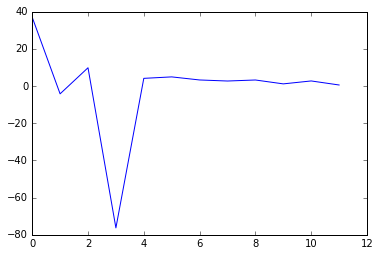

In [46]:
plt.plot(ca[-2])#/np.linalg.norm(ca[-1]))

[  1.11547000e+04   2.00369000e+04   1.79544000e+04   1.83630000e+03
   1.46190000e+03   1.57680000e+03   2.37300000e+02   9.71000000e+01
   8.10000000e+01   7.87000000e+01   1.09300000e+02   2.57000000e+01
   5.00000000e-01] [  97.27697569  168.82976633  261.80649343   61.96620046   97.49302539
  164.14067138   22.38325267    8.04300939    9.61249187   20.73185954
   12.83004287    7.41687266    0.5       ] [ 33.09827405  15.74307693  18.81313154  -2.18990351 -14.01228441
  -6.20321576   7.38498566 -55.31511634 -24.03122968 -11.39791631
  -5.43256174 -16.48942966 -31.        ] [ 7935 17379 13029  1972  2828  2595    72   542   312   315   179   148
    16]


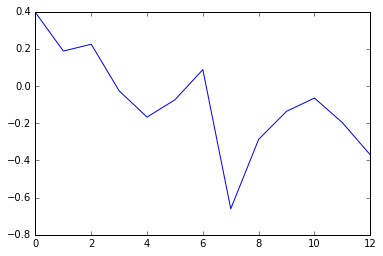

In [20]:
ce=MsigED(C,M3)
plt.plot(ce[-1]/np.linalg.norm(ce[-1]))

In [53]:
cd=MsigDCU(C,M3,M4)
print cd

([(1419.3, 10.450358845513392), (851.0, 20.366639388961548), (502.69999999999999, 30.413977050034084), (656.39999999999998, 2.1071307505705477)], [2542, 1539, 4878, 1595])


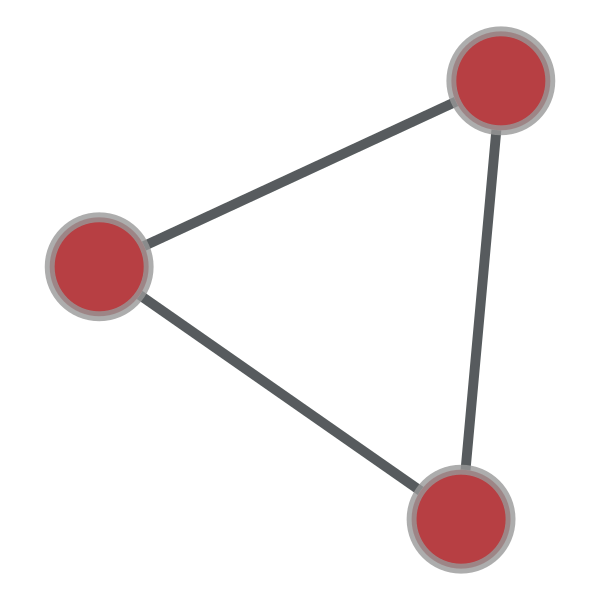

In [125]:
for m in M3:
    ug = gt.GraphView(m)
    graph_draw(ug)

In [24]:
MsigE(C,M3,M4)

([(169.19999999999999, 18.131740126088285),
  (691.0, 61.600324674469043),
  (463.19999999999999, 94.593657292653617),
  (19.899999999999999, 8.0802227692063049)],
 [72, 1857, 202, 2])

In [357]:
motifs(g,4,motif_list=[complete_graph(4)])

([<Graph object, undirected, with 4 vertices and 6 edges at 0x7fee82ab3c50>],
 [0])

In [18]:
def BrainR(name,folder):
    g=load_graph(name)
    vfil=g.new_vertex_property('bool')
    g.vp.rl=vfil
    for v in g.vertices():
        if str(g.vp.dnhemisphere[v])=='right':
            g.vp.rl[v]=True
        else: 
            g.vp.rl[v]=False
    g.set_vertex_filter(g.vp.rl)
    g.purge_vertices()
    g.save(folder+'/'+name.split('/')[-1]+'right.graphml')
    return 0
def BrainL(name,folder):
    g=load_graph(name)
    vfil=g.new_vertex_property('bool')
    g.vp.rl=vfil
    for v in g.vertices():
        if str(g.vp.dnhemisphere[v])=='left':
            g.vp.rl[v]=True
        else: 
            g.vp.rl[v]=False
    g.set_vertex_filter(g.vp.rl)
    g.purge_vertices()
    g.save(folder+'/'+name.split('/')[-1]+'left.graphml')
    return 0
def get_queries(indir): #get list of networks in indir
    queries=[]
    for root, dirs, filenames in os.walk(indir):
        for f in filenames:
            if f[-2:]=="ml": 
                queries.append(os.path.join(root, f))
    queries.sort()
    return queries

In [19]:
import os
os.mkdir('DiBrainL')

In [21]:
q=get_queries('DiBrain')
for i in q:
    BrainR(i,'DiBrainR')
    BrainL(i,'DiBrainL')

In [22]:
g=load_graph('DiBrainF/F100307_.gml')
g.list_properties()
g

directed       (graph)   (type: double, val: 1.0)
dncorrespondenceid (vertex)  (type: string)
dnfsname       (vertex)  (type: string)
dnhemisphere   (vertex)  (type: string)
dnname         (vertex)  (type: string)
dnpositionx    (vertex)  (type: double)
dnpositiony    (vertex)  (type: double)
dnpositionz    (vertex)  (type: double)
dnregion       (vertex)  (type: string)
FAmean         (edge)    (type: double)
FAstd          (edge)    (type: double)
dnmajoritysize (edge)    (type: double)
dnprevalence   (edge)    (type: double)
fiberlengthmean (edge)    (type: double)
fiberlengthstd (edge)    (type: double)
numberoffibers (edge)    (type: double)


<Graph object, directed, with 1015 vertices and 2076 edges at 0x7f2112924150>

In [31]:
g.clear_filters()
vfil=g.new_vertex_property('bool')
g.vp.rl=vfil
for v in g.vertices():
    if str(g.vp.dnhemisphere[v])=='left':
        g.vp.rl[v]=True
    else: 
        g.vp.rl[v]=False
g.set_vertex_filter(g.vp.rl,inverted=True)
print g

<Graph object, directed, with 508 vertices and 1909 edges, edges filtered by (<PropertyMap object with key type 'Edge' and value type 'bool', for Graph 0x7f5cf8f11590, at 0x7f5cf9063950>, False), vertices filtered by (<PropertyMap object with key type 'Vertex' and value type 'bool', for Graph 0x7f5cf8f11590, at 0x7f5cf9063890>, True) at 0x7f5cf8f11590>


In [28]:
import os
os.mkdir('DibrainRL')

In [32]:
g.purge_vertices()
g.save('DibrainRL/right.graphml')

In [145]:
g.set_vertex_filter(label_largest_component(g))
g

<Graph object, undirected, with 379 vertices and 914 edges, edges filtered by (<PropertyMap object with key type 'Edge' and value type 'bool', for Graph 0x7f000e6e4650, at 0x7f00856ff950>, False), vertices filtered by (<PropertyMap object with key type 'Vertex' and value type 'bool', for Graph 0x7f000e6e4650, at 0x7f000e8e7c50>, False) at 0x7f000e6e4650>

In [19]:
g.clear_filters()
for v in g.vertices():
    t=g.vp.dnhemisphere[v]
t

'left'

In [35]:
g=load_graph('DibrainRL/right.graphml')
g

<Graph object, directed, with 508 vertices and 1909 edges, edges filtered by (<PropertyMap object with key type 'Edge' and value type 'bool', for Graph 0x7f5cf9075590, at 0x7f5cf9075690>, 0), vertices filtered by (<PropertyMap object with key type 'Vertex' and value type 'bool', for Graph 0x7f5cf9075590, at 0x7f5cf90750d0>, 0) at 0x7f5cf9075590>

In [147]:
g.save('NetsciLCC/netsciLCC.graphml')

In [149]:
load_graph('NetsciLCC/netsciLCC.graphml')

<Graph object, undirected, with 379 vertices and 914 edges, edges filtered by (<PropertyMap object with key type 'Edge' and value type 'bool', for Graph 0x7f000e581f90, at 0x7f000e8e76d0>, 0), vertices filtered by (<PropertyMap object with key type 'Vertex' and value type 'bool', for Graph 0x7f000e581f90, at 0x7f000e8e7490>, 0) at 0x7f000e581f90>

In [12]:
import networkx as nx
g=nx.read_edgelist('caida/as-caida20040105.txt',data=False,create_using=nx.DiGraph())
nx.info(g)

'Name: \nType: DiGraph\nNumber of nodes: 16301\nNumber of edges: 65910\nAverage in degree:   4.0433\nAverage out degree:   4.0433'

In [14]:
import os
def get_queries(indir): #get list of networks in indir
    queries=[]
    for root, dirs, filenames in os.walk(indir):
        for f in filenames:
            if f[-2:]=="xt": 
                queries.append(os.path.join(root, f))
    queries.sort()
    return queries

In [15]:
os.mkdir('Dicaida')
queries=get_queries('caida')
for q in queries:
    g=nx.read_edgelist(q,data=False,create_using=nx.DiGraph())
    nx.info(g)
    nx.write_gml(g,'Dicaida/'+q.split('/')[-1]+'.gml')